## Importing libraries

In [1]:
#Import libraries for Data Preprocessing & Data Augmentation
import os
import PIL
import numpy as np
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from pathlib import Path
from skimage import io
from PIL import Image
from keras.preprocessing.image import ImageDataGenerator

#Import libraries for Model Implementation 
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow import keras
from keras import layers, optimizers
from keras.layers import Input, Flatten
from keras.models import Sequential, Model
from keras_tuner import RandomSearch
from keras_tuner.engine.hyperparameters import HyperParameters
from keras.applications.resnet import ResNet50
from keras.applications.densenet import DenseNet201
from keras.applications.vgg16 import VGG16
from keras.applications.xception import Xception
import warnings
warnings.simplefilter("ignore")

## Loading and transforming dataset

In [2]:
def extract_feature(path, label):         #Load the images from given path and labeling
    data = []
    for img in os.listdir(path):
        image = cv2.imread(os.path.join(path, img), 0)
        if image is not None:
            data.append([image, label])
    return data

def transform_feature(data):              #Transform dataset using resize, rescale, reshape
    images, labels = [],[]
    size = 128
    for img,label in data:
        images.append((cv2.resize(img,(size,size)))/255)
        labels.append(label)
    img_array = np.array(images)
    X = img_array.reshape(img_array.shape[0],img_array.shape[1],img_array.shape[2],1)
    return X, labels

def vgg_transform_feature(data):         #Transform dataset using resize, rescale, reshape for Xception model
    images, labels = [],[]
    size = 299
    for img,label in data:
        images.append((cv2.resize(img,(size,size)))/255)
        labels.append(label)
    img_array = np.array(images)
    X = img_array.reshape(img_array.shape[0],img_array.shape[1],img_array.shape[2],1)
    return X, labels

In [3]:
data = extract_feature("Dataset_BUSI_with_GT/benign",0) #Call the function to load images with label
data.extend(extract_feature("Dataset_BUSI_with_GT/malignant",1))

In [4]:
X, labels = transform_feature(data)   #Call the function to transform and return with image array & label
X.shape

(1312, 128, 128, 1)

In [5]:
X_train, X_test, Y_train, Y_test = train_test_split(X , labels, train_size=0.75, random_state=42)

### Augmented Data

**Generator for augmenting data**

In [ ]:
data_generator = ImageDataGenerator(       #Parameters for data augmentation
    rotation_range = 20,
    shear_range = 0.2,
    horizontal_flip = True
)

cnt_path = r'Dataset_BUSI_with_GT/benign/'
size = 224
img_list = []
images = os.listdir(cnt_path)
for _, img_name in enumerate(images):    
    if (img_name.split('.')[1] == 'png'):        
        img = io.imread(cnt_path + img_name)        
        img = Image.fromarray(img, 'RGB')        
        img = img.resize((size,size)) 
        img_list.append(np.array(img))
img_array = np.array(img_list)
i = 0
for _ in data_generator.flow(img_array, batch_size=8, save_to_dir= r'aug_data/benign', 
                             save_prefix='aug', save_format='png'):    
    i += 1    
    if i > 100:        
        break

In [6]:
def aug_transform_feature(data):              #Transform dataset using resize, rescale, reshape
    images, labels = [],[]
    size=128
    for img,label in data:
        images.append((cv2.resize(img,(size,size)))/255)
        labels.append(label)
    img_array = np.array(images)
    X = img_array.reshape(img_array.shape[0],img_array.shape[1],img_array.shape[2],1)
    return X, labels

In [7]:
aug_data = extract_feature("aug_data/benign",0)
aug_data.extend(extract_feature("aug_data/malignant",1))

In [8]:
x, label = aug_transform_feature(aug_data)
x.shape

(3057, 128, 128, 1)

In [9]:
x_train, x_test, y_train, y_test = train_test_split(x , label, train_size=0.75, random_state=42)

**Function for classification report of any model**

In [10]:
def report(model, aug = False):
    if aug:
        xtest = x_test
        y_true = y_test
    else:
        xtest = X_test
        y_true = Y_test
    y_pred = []
    for i in model.predict(xtest,batch_size=10,verbose=0):
        y_pred.append(np.argmax(i))
    print(classification_report(y_true, y_pred, target_names= ['benign','malignant']))

# BASE MODEL

In [11]:
#First Base Model 
model1 = Sequential([
    layers.Conv2D(16, 4, padding = 'same', activation = 'relu', input_shape=(128,128,1)),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 4, padding = 'same', activation = 'relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 4, padding = 'same', activation = 'relu'),
    layers.MaxPooling2D(),
    layers.BatchNormalization(),
    layers.Flatten(),
    layers.Dense(128, activation = 'relu'),
    layers.Dropout(0.3),
    layers.Dense(64, activation = 'relu'),
    layers.Dropout(0.3),
    layers.Dense(32, activation = 'relu'),
    layers.Dropout(0.3),
    layers.Dense(2, activation = 'softmax')
])

#Compile the model with optimizer and metrics
model1.compile(optimizer = 'adam',
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
              metrics = ['accuracy'])

#Review the model summary
model1.summary()

Metal device set to: Apple M1
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 16)      272       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        8224      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 64)        32832     
                                                                 
 max_pooling2d_2 (MaxPooli

2022-02-21 21:52:21.911551: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-02-21 21:52:21.911641: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [24]:
#Train the model
result = model1.fit(np.array(X_train), np.array(Y_train), epochs = 25,
                    validation_data=(X_test, np.array(Y_test)), verbose = 2)

Epoch 1/25
31/31 - 2s - loss: 0.0800 - accuracy: 0.9807 - val_loss: 3.2372 - val_accuracy: 0.7805 - 2s/epoch - 49ms/step
Epoch 2/25
31/31 - 1s - loss: 0.0185 - accuracy: 0.9929 - val_loss: 1.5409 - val_accuracy: 0.8110 - 1s/epoch - 44ms/step
Epoch 3/25
31/31 - 1s - loss: 0.0117 - accuracy: 0.9949 - val_loss: 0.9976 - val_accuracy: 0.8445 - 1s/epoch - 44ms/step
Epoch 4/25
31/31 - 1s - loss: 0.0175 - accuracy: 0.9959 - val_loss: 0.7699 - val_accuracy: 0.8598 - 1s/epoch - 44ms/step
Epoch 5/25
31/31 - 1s - loss: 0.0063 - accuracy: 0.9970 - val_loss: 0.7555 - val_accuracy: 0.8659 - 1s/epoch - 44ms/step
Epoch 6/25
31/31 - 1s - loss: 0.0055 - accuracy: 0.9980 - val_loss: 0.9049 - val_accuracy: 0.8445 - 1s/epoch - 43ms/step
Epoch 7/25
31/31 - 1s - loss: 0.0037 - accuracy: 0.9980 - val_loss: 0.8835 - val_accuracy: 0.8628 - 1s/epoch - 43ms/step
Epoch 8/25
31/31 - 1s - loss: 0.0077 - accuracy: 0.9970 - val_loss: 0.8420 - val_accuracy: 0.8659 - 1s/epoch - 44ms/step
Epoch 9/25
31/31 - 1s - loss: 0.

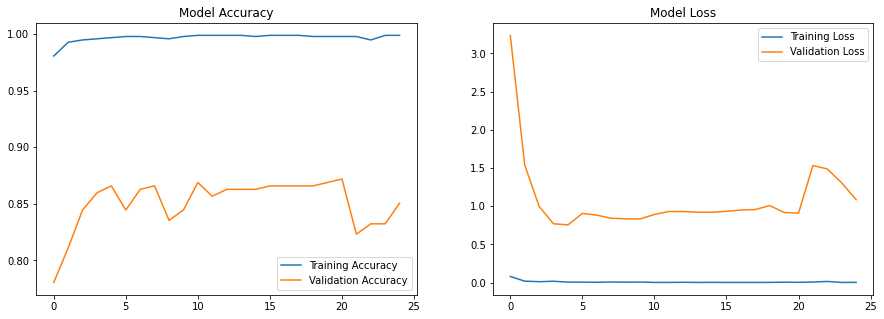

In [26]:
#Model performance
accuracy = result.history['accuracy']
val_accuracy = result.history['val_accuracy']
loss = result.history['loss']
val_loss = result.history['val_loss']

epochs = range(25)

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, accuracy, label='Training Accuracy')
plt.plot(epochs, val_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Model Accuracy')
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Model Loss')
plt.show()

In [27]:
report(model1)        #Classification Report

              precision    recall  f1-score   support

      benign       0.87      0.92      0.89       227
   malignant       0.79      0.70      0.74       101

    accuracy                           0.85       328
   macro avg       0.83      0.81      0.82       328
weighted avg       0.85      0.85      0.85       328



## BASE Model with Augmentation

In [28]:
#First base model
model2 = Sequential([
    layers.Conv2D(16, 3, padding = 'same', activation = 'relu', input_shape=(128,128,1)),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding = 'same', activation = 'relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding = 'same', activation = 'relu'),
    layers.MaxPooling2D(),
    layers.BatchNormalization(),
    layers.Flatten(),
    layers.Dense(128, activation = 'relu'),
    layers.Dropout(0.3),
    layers.Dense(64, activation = 'relu'),
    layers.Dropout(0.3),
    layers.Dense(32, activation = 'relu'),
    layers.Dropout(0.3),
    layers.Dense(2, activation = 'softmax')
])

#Compile the model with optimizer and metrics
model2.compile(optimizer = 'adam',
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
              metrics = ['accuracy'])

#Review the model summary
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 128, 128, 16)      160       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 64, 64, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 64, 64, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 32, 32, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 16, 16, 64)      

In [29]:
#Train the model
result = model2.fit(np.array(x_train), np.array(y_train), epochs = 50,
                    validation_data=(x_test, np.array(y_test)), verbose = 2)

Epoch 1/50


2022-02-21 22:10:08.243177: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-21 22:10:11.161192: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


72/72 - 4s - loss: 0.5767 - accuracy: 0.7129 - val_loss: 0.6846 - val_accuracy: 0.4288 - 4s/epoch - 52ms/step
Epoch 2/50
72/72 - 3s - loss: 0.4224 - accuracy: 0.8080 - val_loss: 0.6295 - val_accuracy: 0.7935 - 3s/epoch - 39ms/step
Epoch 3/50
72/72 - 3s - loss: 0.3325 - accuracy: 0.8560 - val_loss: 0.6015 - val_accuracy: 0.8078 - 3s/epoch - 38ms/step
Epoch 4/50
72/72 - 3s - loss: 0.2725 - accuracy: 0.8752 - val_loss: 0.5309 - val_accuracy: 0.8471 - 3s/epoch - 38ms/step
Epoch 5/50
72/72 - 3s - loss: 0.2219 - accuracy: 0.9066 - val_loss: 0.4428 - val_accuracy: 0.8549 - 3s/epoch - 38ms/step
Epoch 6/50
72/72 - 3s - loss: 0.1732 - accuracy: 0.9337 - val_loss: 0.3842 - val_accuracy: 0.8510 - 3s/epoch - 38ms/step
Epoch 7/50
72/72 - 3s - loss: 0.1226 - accuracy: 0.9503 - val_loss: 0.3073 - val_accuracy: 0.8876 - 3s/epoch - 38ms/step
Epoch 8/50
72/72 - 3s - loss: 0.0998 - accuracy: 0.9638 - val_loss: 0.3002 - val_accuracy: 0.8667 - 3s/epoch - 38ms/step
Epoch 9/50
72/72 - 3s - loss: 0.0869 - accu

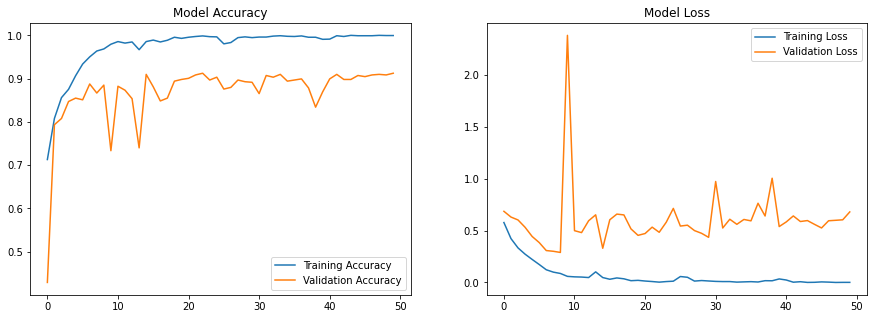

In [30]:
#Model performance
accuracy = result.history['accuracy']
val_accuracy = result.history['val_accuracy']
loss = result.history['loss']
val_loss = result.history['val_loss']

epochs = range(50)

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, accuracy, label='Training Accuracy')
plt.plot(epochs, val_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Model Accuracy')
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Model Loss')
plt.show()

In [31]:
report(model2, True)

2022-02-21 22:13:42.081743: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


              precision    recall  f1-score   support

      benign       0.88      0.91      0.90       328
   malignant       0.93      0.91      0.92       437

    accuracy                           0.91       765
   macro avg       0.91      0.91      0.91       765
weighted avg       0.91      0.91      0.91       765



# BASE Model with Keras Tuner

In [32]:
def tuned_model(hp):  #Function for tuning model
  model = keras.Sequential([
    layers.Conv2D(
        filters=hp.Int('conv_1_filter', min_value=16, max_value=64, step=16),
        kernel_size=hp.Choice('conv_1_kernel', values = [4,5]),
        activation='relu',
        input_shape=(128,128,1)
    ),
    layers.MaxPooling2D(),
    layers.Conv2D(
        filters=hp.Int('conv_1_filter', min_value=64, max_value=128, step=16),
        kernel_size=hp.Choice('conv_1_kernel', values = [4,5]), 
        activation='relu', 
        input_shape=(128,128,1)),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(units = hp.Int('dense_1_units', min_value=32, max_value=128, step=32), activation='relu'),
    layers.Dense(2, activation='softmax')
  ])
  
  model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
  
  return model

In [33]:
random_search = RandomSearch(tuned_model, objective='val_accuracy',
                          max_trials = 3, directory = 'output', project_name = "bcc")

In [34]:
#Search best parameters by training model
random_search.search(np.array(X_train), np.array(Y_train), epochs = 5, validation_data=(X_test, np.array(Y_test)))

Trial 3 Complete [00h 00m 16s]
val_accuracy: 0.8018292784690857

Best val_accuracy So Far: 0.8048780560493469
Total elapsed time: 00h 00m 31s
INFO:tensorflow:Oracle triggered exit


In [35]:
model3 = random_search.get_best_models(num_models=1)[0]  #Find the best parameter model
model3.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 124, 124, 16)      416       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 62, 62, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 58, 58, 16)        6416      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 29, 29, 16)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 13456)             0         
                                                                 
 dense (Dense)               (None, 128)               1

In [36]:
result = model3.fit(np.array(X_train), np.array(Y_train), epochs = 25, 
            validation_data=(X_test, np.array(Y_test)), initial_epoch=5)

Epoch 6/25
 3/31 [=>............................] - ETA: 0s - loss: 0.1759 - accuracy: 0.9167

2022-02-21 22:18:00.505883: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


31/31 [==============================] - 1s 37ms/step - loss: 0.1638 - accuracy: 0.9390 - val_loss: 0.5265 - val_accuracy: 0.8201


2022-02-21 22:18:01.583925: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Epoch 7/25
31/31 [==============================] - 1s 33ms/step - loss: 0.0970 - accuracy: 0.9634 - val_loss: 0.6342 - val_accuracy: 0.7866
Epoch 8/25
31/31 [==============================] - 1s 33ms/step - loss: 0.0515 - accuracy: 0.9848 - val_loss: 0.7591 - val_accuracy: 0.8140
Epoch 9/25
31/31 [==============================] - 1s 33ms/step - loss: 0.0668 - accuracy: 0.9766 - val_loss: 0.6556 - val_accuracy: 0.7866
Epoch 10/25
31/31 [==============================] - 1s 33ms/step - loss: 0.0336 - accuracy: 0.9878 - val_loss: 0.7195 - val_accuracy: 0.8262
Epoch 11/25
31/31 [==============================] - 1s 33ms/step - loss: 0.0172 - accuracy: 0.9970 - val_loss: 0.8460 - val_accuracy: 0.8018
Epoch 12/25
31/31 [==============================] - 1s 33ms/step - loss: 0.0146 - accuracy: 0.9970 - val_loss: 0.7575 - val_accuracy: 0.8201
Epoch 13/25
31/31 [==============================] - 1s 34ms/step - loss: 0.0151 - accuracy: 0.9980 - val_loss: 0.8253 - val_accuracy: 0.8049
Epoch 14/

In [37]:
report(model3)

              precision    recall  f1-score   support

      benign       0.84      0.92      0.88       227
   malignant       0.76      0.60      0.67       101

    accuracy                           0.82       328
   macro avg       0.80      0.76      0.77       328
weighted avg       0.82      0.82      0.81       328



2022-02-21 22:20:33.236071: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


## BASE Model with Keras Tuner & Augmentation

In [39]:
random_search = RandomSearch(tuned_model, objective='val_accuracy',
                          max_trials = 3, directory = 'output', project_name = "augbcc")

In [40]:
#Search best parameters by training model
random_search.search(np.array(x_train), np.array(y_train), epochs = 5, validation_data=(x_test, np.array(y_test)))

Trial 3 Complete [00h 00m 57s]
val_accuracy: 0.8535947799682617

Best val_accuracy So Far: 0.8535947799682617
Total elapsed time: 00h 02m 12s
INFO:tensorflow:Oracle triggered exit


In [41]:
model4 = random_search.get_best_models(num_models=1)[0]   #Find the best parameter model
model4.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 124, 124, 64)      1664      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 62, 62, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 58, 58, 64)        102464    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 29, 29, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 53824)             0         
                                                                 
 dense (Dense)               (None, 96)                5

In [42]:
result= model4.fit(np.array(x_train), np.array(y_train), epochs = 25, 
            validation_data=(x_test, np.array(y_test)), initial_epoch=5)

Epoch 6/25


2022-02-21 22:23:27.131869: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


72/72 [==============================] - ETA: 0s - loss: 0.2322 - accuracy: 0.9084

2022-02-21 22:23:37.082338: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


72/72 [==============================] - 12s 158ms/step - loss: 0.2322 - accuracy: 0.9084 - val_loss: 0.3276 - val_accuracy: 0.8523
Epoch 7/25
72/72 [==============================] - 11s 154ms/step - loss: 0.1424 - accuracy: 0.9446 - val_loss: 0.3488 - val_accuracy: 0.8575
Epoch 8/25
72/72 [==============================] - 11s 153ms/step - loss: 0.0982 - accuracy: 0.9682 - val_loss: 0.3816 - val_accuracy: 0.8784
Epoch 9/25
72/72 [==============================] - 11s 154ms/step - loss: 0.0841 - accuracy: 0.9716 - val_loss: 0.3330 - val_accuracy: 0.8876
Epoch 10/25
72/72 [==============================] - 11s 154ms/step - loss: 0.0480 - accuracy: 0.9847 - val_loss: 0.3691 - val_accuracy: 0.8784
Epoch 11/25
72/72 [==============================] - 11s 155ms/step - loss: 0.0293 - accuracy: 0.9926 - val_loss: 0.3405 - val_accuracy: 0.8810
Epoch 12/25
72/72 [==============================] - 11s 154ms/step - loss: 0.0193 - accuracy: 0.9956 - val_loss: 0.3843 - val_accuracy: 0.8863
Epoch 1

In [43]:
report(model4, True)

2022-02-21 22:27:25.021127: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


              precision    recall  f1-score   support

      benign       0.85      0.89      0.87       328
   malignant       0.91      0.88      0.90       437

    accuracy                           0.88       765
   macro avg       0.88      0.88      0.88       765
weighted avg       0.89      0.88      0.88       765



# AlexNet

In [44]:
model5 = Sequential([
    layers.Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(128,128,1)),
    layers.BatchNormalization(),
    layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),
    layers.BatchNormalization(),
    layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    layers.BatchNormalization(),
    layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    layers.BatchNormalization(),
    layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    layers.BatchNormalization(),
    layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    layers.Flatten(),
    layers.Dense(4096, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(4096, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(2, activation='softmax')
])
    
model5.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model5.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 30, 30, 96)        11712     
                                                                 
 batch_normalization (BatchN  (None, 30, 30, 96)       384       
 ormalization)                                                   
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 96)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 14, 14, 256)       614656    
                                                                 
 batch_normalization_1 (Batc  (None, 14, 14, 256)      1024      
 hNormalization)                                                 
                                                      

In [45]:
model5.fit(np.array(X_train), np.array(Y_train), epochs = 25, validation_data=(X_test, np.array(Y_test)), verbose = 2,
          validation_freq=1)

Epoch 1/25


2022-02-21 22:27:36.057543: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-21 22:27:38.966912: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


31/31 - 3s - loss: 3.1556 - accuracy: 0.6209 - val_loss: 0.5536 - val_accuracy: 0.7165 - 3s/epoch - 112ms/step
Epoch 2/25
31/31 - 3s - loss: 0.6343 - accuracy: 0.6585 - val_loss: 0.6312 - val_accuracy: 0.6829 - 3s/epoch - 86ms/step
Epoch 3/25
31/31 - 3s - loss: 0.5872 - accuracy: 0.7022 - val_loss: 0.5813 - val_accuracy: 0.7134 - 3s/epoch - 85ms/step
Epoch 4/25
31/31 - 3s - loss: 0.5495 - accuracy: 0.7510 - val_loss: 0.8983 - val_accuracy: 0.3079 - 3s/epoch - 85ms/step
Epoch 5/25
31/31 - 3s - loss: 0.5182 - accuracy: 0.7307 - val_loss: 0.8416 - val_accuracy: 0.2774 - 3s/epoch - 85ms/step
Epoch 6/25
31/31 - 3s - loss: 0.4933 - accuracy: 0.7642 - val_loss: 1.0805 - val_accuracy: 0.2805 - 3s/epoch - 86ms/step
Epoch 7/25
31/31 - 3s - loss: 0.4371 - accuracy: 0.7957 - val_loss: 1.1130 - val_accuracy: 0.3323 - 3s/epoch - 85ms/step
Epoch 8/25
31/31 - 3s - loss: 0.4617 - accuracy: 0.8049 - val_loss: 0.8959 - val_accuracy: 0.4177 - 3s/epoch - 85ms/step
Epoch 9/25
31/31 - 3s - loss: 0.5335 - acc

In [46]:
report(model5)

2022-02-21 22:32:48.257792: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


              precision    recall  f1-score   support

      benign       0.91      0.79      0.84       227
   malignant       0.63      0.82      0.72       101

    accuracy                           0.80       328
   macro avg       0.77      0.81      0.78       328
weighted avg       0.82      0.80      0.80       328



# ResNet50

In [47]:
restnet = ResNet50(include_top = False, weights= None , input_shape=(128, 128, 1))
output = restnet.layers[-1].output
output = layers.Flatten()(output)

restnet = Model(restnet.input, output)

for layer in restnet.layers:
    layer.trainable = False

model6 = Sequential([
            restnet,
            layers.Dense(2, activation="softmax")
])

model6.compile(loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
optimizer='adam',
metrics=['accuracy'])
model6.summary() 

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model (Functional)          (None, 32768)             23581440  
                                                                 
 dense_5 (Dense)             (None, 2)                 65538     
                                                                 
Total params: 23,646,978
Trainable params: 65,538
Non-trainable params: 23,581,440
_________________________________________________________________


In [48]:
result = model6.fit(
    np.array(X_train),
    np.array(Y_train),
    steps_per_epoch=len(X_train),
    epochs=10,
    validation_data=(X_test, np.array(Y_test)),
    validation_steps=len(X_test),
    verbose=2
)

Epoch 1/10


2022-02-21 22:33:13.048860: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-21 22:33:26.376702: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


984/984 - 19s - loss: 1.3144 - accuracy: 0.6087 - val_loss: 1.1491 - val_accuracy: 0.5396 - 19s/epoch - 19ms/step
Epoch 2/10
984/984 - 17s - loss: 1.0267 - accuracy: 0.6646 - val_loss: 0.8376 - val_accuracy: 0.7012 - 17s/epoch - 17ms/step
Epoch 3/10
984/984 - 17s - loss: 0.9800 - accuracy: 0.6829 - val_loss: 0.6102 - val_accuracy: 0.7439 - 17s/epoch - 17ms/step
Epoch 4/10
984/984 - 16s - loss: 0.9087 - accuracy: 0.7083 - val_loss: 1.3309 - val_accuracy: 0.5122 - 16s/epoch - 17ms/step
Epoch 5/10
984/984 - 16s - loss: 0.8343 - accuracy: 0.7185 - val_loss: 1.2450 - val_accuracy: 0.7195 - 16s/epoch - 17ms/step
Epoch 6/10
984/984 - 16s - loss: 1.0682 - accuracy: 0.7063 - val_loss: 1.7599 - val_accuracy: 0.7012 - 16s/epoch - 17ms/step
Epoch 7/10
984/984 - 16s - loss: 0.7321 - accuracy: 0.7541 - val_loss: 0.6298 - val_accuracy: 0.7500 - 16s/epoch - 17ms/step
Epoch 8/10
984/984 - 17s - loss: 0.7980 - accuracy: 0.7246 - val_loss: 0.8307 - val_accuracy: 0.7561 - 17s/epoch - 17ms/step
Epoch 9/10


In [49]:
report(model6)

2022-02-21 22:37:41.769771: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


              precision    recall  f1-score   support

      benign       0.79      0.90      0.85       227
   malignant       0.69      0.48      0.56       101

    accuracy                           0.77       328
   macro avg       0.74      0.69      0.70       328
weighted avg       0.76      0.77      0.76       328



# DenseNet 201

In [50]:
densenet = DenseNet201(include_top = False, weights = None , input_shape = (128, 128, 1))
output = densenet.layers[-1].output
output = keras.layers.Flatten()(output)

densenet = Model(densenet.input, output)

for layer in densenet.layers:
    layer.trainable = False

model7 = Sequential([
            densenet,
            layers.Dense(2, activation="softmax")
])

model7.compile( loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
optimizer='adam',
metrics=[ 'accuracy'])
model7.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model_1 (Functional)        (None, 30720)             18315712  
                                                                 
 dense_6 (Dense)             (None, 2)                 61442     
                                                                 
Total params: 18,377,154
Trainable params: 61,442
Non-trainable params: 18,315,712
_________________________________________________________________


In [51]:
result = model7.fit(
    np.array(X_train),
    np.array(Y_train),
    steps_per_epoch=len(X_train),
    epochs=10,
    validation_data=(X_test, np.array(Y_test)),
    validation_steps=len(Y_test),
    verbose=2
)

Epoch 1/10


2022-02-21 22:38:05.751683: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-21 22:38:44.253460: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


984/984 - 56s - loss: 0.6416 - accuracy: 0.6646 - val_loss: 0.6317 - val_accuracy: 0.7043 - 56s/epoch - 57ms/step
Epoch 2/10
984/984 - 51s - loss: 0.5993 - accuracy: 0.7104 - val_loss: 0.5860 - val_accuracy: 0.7530 - 51s/epoch - 52ms/step
Epoch 3/10
984/984 - 52s - loss: 0.5682 - accuracy: 0.7154 - val_loss: 0.5704 - val_accuracy: 0.7744 - 52s/epoch - 53ms/step
Epoch 4/10
984/984 - 51s - loss: 0.5504 - accuracy: 0.7388 - val_loss: 0.5469 - val_accuracy: 0.7348 - 51s/epoch - 52ms/step
Epoch 5/10
984/984 - 51s - loss: 0.5297 - accuracy: 0.7612 - val_loss: 0.5264 - val_accuracy: 0.7530 - 51s/epoch - 52ms/step
Epoch 6/10
984/984 - 50s - loss: 0.5223 - accuracy: 0.7663 - val_loss: 0.5362 - val_accuracy: 0.7317 - 50s/epoch - 51ms/step
Epoch 7/10
984/984 - 51s - loss: 0.5124 - accuracy: 0.7693 - val_loss: 0.5126 - val_accuracy: 0.7622 - 51s/epoch - 52ms/step
Epoch 8/10
984/984 - 51s - loss: 0.4973 - accuracy: 0.7754 - val_loss: 0.5195 - val_accuracy: 0.7591 - 51s/epoch - 51ms/step
Epoch 9/10


In [52]:
report(model7)

2022-02-21 22:46:46.113868: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


              precision    recall  f1-score   support

      benign       0.75      0.95      0.84       227
   malignant       0.71      0.30      0.42       101

    accuracy                           0.75       328
   macro avg       0.73      0.62      0.63       328
weighted avg       0.74      0.75      0.71       328



# VGG16

In [53]:
X, labels = vgg_transform_feature(data)   #Call the function to transform and return with image array & label
X_train, X_test, Y_train, Y_test = train_test_split(X , labels, train_size=0.75, random_state=42)

In [54]:
vgg = VGG16(input_shape = (299, 299, 1), weights=None, include_top=False)

for layer in vgg.layers:       #To freeze the previous layers
  layer.trainable = False

x = Flatten()(vgg.output)
output = layers.Dense(2, activation='softmax')(x)

model8 = Model(inputs=vgg.input, outputs=output)
model8.compile(
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
  optimizer='adam',
  metrics=['accuracy']
)
model8.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 299, 299, 1)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 299, 299, 64)      640       
                                                                 
 block1_conv2 (Conv2D)       (None, 299, 299, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 149, 149, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 149, 149, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 149, 149, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 74, 74, 128)       0   

In [55]:
result = model8.fit(
    np.array(X_train),
    np.array(Y_train),
    steps_per_epoch=len(X_train),
    epochs=10,
    validation_data=(X_test, np.array(Y_test)),
    validation_steps=len(Y_test),
    verbose=2
)

Epoch 1/10


2022-02-21 22:47:22.237331: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-21 22:47:53.785357: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


984/984 - 42s - loss: 0.6490 - accuracy: 0.6677 - val_loss: 0.6332 - val_accuracy: 0.6921 - 42s/epoch - 43ms/step
Epoch 2/10
984/984 - 42s - loss: 0.6279 - accuracy: 0.6758 - val_loss: 0.6166 - val_accuracy: 0.6982 - 42s/epoch - 42ms/step
Epoch 3/10
984/984 - 42s - loss: 0.6147 - accuracy: 0.6921 - val_loss: 0.6044 - val_accuracy: 0.7043 - 42s/epoch - 42ms/step
Epoch 4/10
984/984 - 41s - loss: 0.6069 - accuracy: 0.6951 - val_loss: 0.6020 - val_accuracy: 0.7012 - 41s/epoch - 42ms/step
Epoch 5/10
984/984 - 41s - loss: 0.5976 - accuracy: 0.6951 - val_loss: 0.5868 - val_accuracy: 0.7134 - 41s/epoch - 42ms/step
Epoch 6/10
984/984 - 41s - loss: 0.5912 - accuracy: 0.6992 - val_loss: 0.5797 - val_accuracy: 0.7165 - 41s/epoch - 42ms/step
Epoch 7/10
984/984 - 70s - loss: 0.5850 - accuracy: 0.6992 - val_loss: 0.5733 - val_accuracy: 0.7226 - 70s/epoch - 71ms/step
Epoch 8/10
984/984 - 41s - loss: 0.5812 - accuracy: 0.6992 - val_loss: 0.5673 - val_accuracy: 0.7195 - 41s/epoch - 42ms/step
Epoch 9/10


In [56]:
report(model8)

2022-02-21 22:57:22.839591: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


              precision    recall  f1-score   support

      benign       0.72      0.98      0.83       227
   malignant       0.80      0.16      0.26       101

    accuracy                           0.73       328
   macro avg       0.76      0.57      0.55       328
weighted avg       0.75      0.73      0.66       328

